In [247]:
#载入所需package
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping 
import cmath
from torch import nn
import random
from torch.utils import data
import copy
from scipy.special import kv
from scipy import integrate
import seaborn as sns
import matplotlib as mpl

In [2]:
#标准 generator
class generator_t:
    def __init__(self,df,mu = 0, sigma = 1,samplesize = 1000, h = 0.01):
        self.df = df
        self.mu = mu
        self.sigma = sigma
        self.samplesize = samplesize
        self.frequency = h
    @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)
    
    def generate_standard_t(self):
        d0 = np.random.standard_t(self.df, (self.samplesize,1))
        d1 = self.cumulate(d0)
        delta = torch.tensor(d0)
        data = torch.tensor(d1)
        delta.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
        return delta,data

In [7]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = (math.sqrt(s**2+c**2))**h
                theta = math.atan(s/c)*h
                c_h = r*math.cos(theta)
                s_h = r*math.sin(theta)
                R = R+[c_h]
                R = R+[s_h]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    

In [229]:
class rejection_method:    
    def __init__(self,h,n,v,mu = 0,sigma = 1):        
        self.h = h
        self.v = v
        self.mu = mu
        self.sigma = sigma
        self.n = n
    def phi_h(self,t):
        phi_real = math.cos(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        phi_imag = math.sin(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        r = (math.sqrt(phi_real**2+phi_imag**2))**self.h
        theta = math.atan(phi_imag/phi_real)*self.h
        phi_real = r*math.cos(theta)
        phi_imag = r*math.sin(theta)
        phi_abs = math.sqrt(phi_real**2+phi_imag**2)
        return phi_real, phi_imag, phi_abs
    def f(self,x,t_lim=200,t_num=2000):
        t = torch.linspace(-int(t_lim),int(t_lim),t_num)
        intg = []
        #因为密度是real的
        for i in range(t_num):
            r = self.phi_h(t[i])[0]
            im = self.phi_h(t[i])[1]
            intg += [math.cos(t[i]*x)*r+math.sin(t[i]*x)*im]
        y = 1/(2*math.pi)*integrate.trapz(intg, t)
        return y
    def phi_abs0(self,t):
        return self.phi_h(t)[2]
    def phi_prime(self,t,delt = 0.01):
        d_1 = (self.phi_h(t)[0]-self.phi_h(t+delt)[0])/delt
        d_2 = (self.phi_h(t)[1]-self.phi_h(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2
    def phi_prime_prime(self,t,delt = 0.01):
        d_1 = (self.phi_prime(t)[0]-self.phi_prime(t+delt)[0])/delt
        d_2 = (self.phi_prime(t)[1]-self.phi_prime(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2,d_abs  
    def phi_abs2(self,t):
        return self.phi_prime_prime(t)[2]
    def integ(self,domain = 100,ndots = 500):
        t = torch.linspace(-int(domain),int(domain),ndots)
        intg_0 = []
        intg_2 = []
        for i in range(len(t)):
            intg_0 += [self.phi_abs0(t[i])]
        c = 1/(2*math.pi)*integrate.trapz(intg_0, t)
        for i in range(len(t)):
            intg_2 += [self.phi_abs2(t[i])]
        k = 1/(2*math.pi)*integrate.trapz(intg_2, t)
        return c,k
    def hat_function(self,x):        
        c,k = self.integ()
        g = min(c,k/(x**2))
        return g

    def genertator(self):
        total = 25*self.n
        V_1 = np.random.uniform(-1,1,total)
        V_2 = np.random.uniform(-1,1,total)
        c,k = self.integ()
        X = []
        for i in range(total):
            y = math.sqrt(k/c)*(V_1[i]/V_2[i])
            U = np.random.uniform(-1,1)            
            if len(X) >=self.n:
                break
                
            elif U<= (self.f(y)/self.hat_function(y)):
                X+=[y]
            else:
                continue
        return X
        
        @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)    

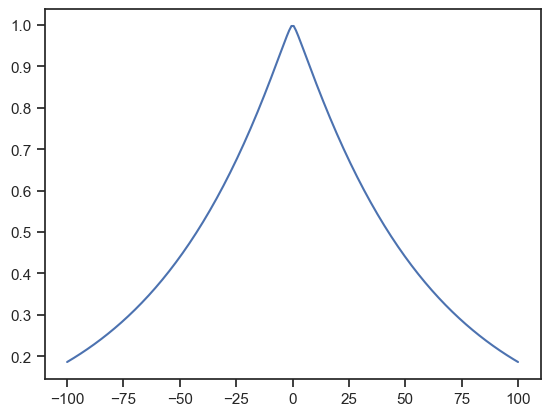

In [230]:
rm = rejection_method(h = 0.01,n = 1000,v =3)
t = torch.linspace(-100,100,200)
intg_0 = []
for i in range(len(t)):
    intg_0 += [rm.phi_abs0(t[i])]
plt.plot(t,intg_0)

In [236]:
x = rm.genertator()


KeyboardInterrupt: 

In [246]:
X = torch.tensor(x)
x_show = []
for i in range(len(x)):
    if abs(x[i])<1:
        x_show+=[x[i]]
len(x_show)

994

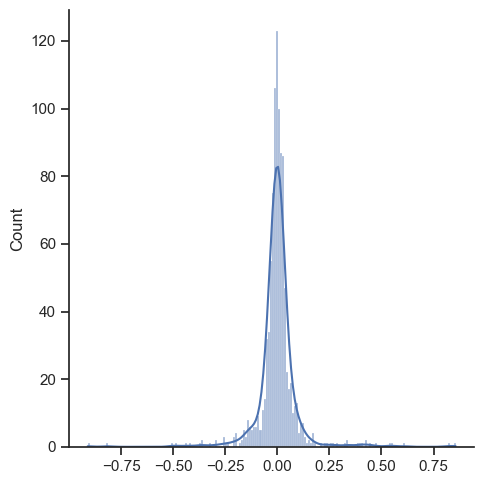

In [245]:
fig = sns.displot(data = x_show,kind = 'hist',kde = "TRUE")


In [228]:
len([])

0